In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
#importing the necessary libraries
import sys
import cv2
import torch
import torchvision
import numpy as np 
import pandas as pd
from torch import nn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split

In [27]:
df = pd.read_csv('/content/drive/MyDrive/DeepLearning_Dataset/Train.csv')

In [28]:
#splitting the data into training,testing and validation datasets

train_data, val_data, test_data = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])


In [29]:
def mask_to_class_rgb(mask):
    color_dict={
    0: (0, 0, 0),  # Background
    1: (250,250,55),  # Class 1 represents Person
    2: (255,0,124),   # Class 2 represents Furniture
    3: (50,183,250),  # Class 3 represents Building
    4: (255,106,77),  # Class 4 represents Car
    5: (61,61,245),   # Class 5 represents Pole
    }
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()
    # Creating a new numpy array 
    rgb_mask = np.zeros((320, 320, 3), dtype=np.uint8)

    for row in range(320):
        for column in range(320):
            class_index = mask[0][row][column]
            rgb_mask[row][column] = color_dict[class_index]

    return rgb_mask
        
def index_mask_class(mask):

    color_to_class_dict = {
      (0, 0, 0): 0,      # Black pixel represents background
      (250,250,55): 1,   # Represents Person
      (255,0,124):  2,   # Represents Furniture
      (50,183,250): 3,   # Represents Building
      (255,106,77): 4,   # Represents Car
      (61,61,245):  5,   # Represents Pole
    }

  
    mask_image = Image.open(mask)
    mask_image = mask_image.resize((320, 320))
    mask_array = np.array(mask_image)
    class_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)
    for color, class_idx in color_to_class_dict.items():
        color_indices = np.where(np.all(mask_array == color, axis=-1))
        class_indices[color_indices] = class_idx
    return class_indices

In [30]:
class CustomImageDataset(Dataset):
    
    def __init__(self, df, transform=None, mean=None, std=None):
        
        self.df = df
        self.transform = transform
        self.mean = mean
        self.std = std
        
        if self.mean is not None and self.std is not None:
            self.normalize = transforms.Normalize(mean=self.mean, std=self.std)
        else:
            self.normalize = None
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        dir_path = "/content/drive/MyDrive/DeepLearning_Dataset/"
        image_path = dir_path + row.OriginalImages
        AnnotatedImage_path  =  dir_path + row.AnnotatedImages
        image = Image.open(image_path).convert("RGB")
        mask_img = index_mask_class(AnnotatedImage_path)
        mask_img = np.expand_dims(mask_img, axis=-1) #(h,w,1)
        #(h,w,c) -> (c,h,w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask_img = np.transpose(mask_img, (2, 0, 1)).astype(np.float32)
        
        if self.transform is not None:
            image = self.transform(torch.Tensor(image))
        
        if self.normalize is not None:
            image = self.normalize(image)
        
        return image, torch.Tensor(mask_img)


In [31]:
# Calculate mean and standard deviation of the training set
train_images = []
for i in range(len(train_data)):
    row = train_data.iloc[i]
    image_path = dir_path + row['OriginalImages']
    train_image = Image.open(image_path)
    train_image = train_image.resize((320, 320))
    train_images.append(np.array(train_image))

train_images_array = np.array(train_images)
mean = np.mean(train_images_array, axis=(0, 1, 2))
std = np.std(train_images_array, axis=(0, 1, 2))



In [32]:
train_dataSet = CustomImageDataset(train_data, transform=transforms.ToTensor(), mean=mean, std=std)
valid_dataSet = CustomImageDataset(val_data, transform=transforms.ToTensor(), mean=mean, std=std)
test_dataSet = CustomImageDataset(test_data, transform=transforms.ToTensor(), mean=mean, std=std)

In [33]:
#Splitting the data in batch wise
train_dataLoader, val_dataLoader, test_dataLoader = [DataLoader(dataset, batch_size=8, shuffle=True) 
                                                    for dataset in [train_dataSet, valid_dataSet, test_dataSet]]


In [34]:
image, mask = next(iter(train_dataLoader))
print(f'One batch image shape: {image.shape}')
print(f'One batch mask shape: {mask.shape}')


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


One batch image shape: torch.Size([8, 3, 320, 320])
One batch mask shape: torch.Size([8, 1, 320, 320])


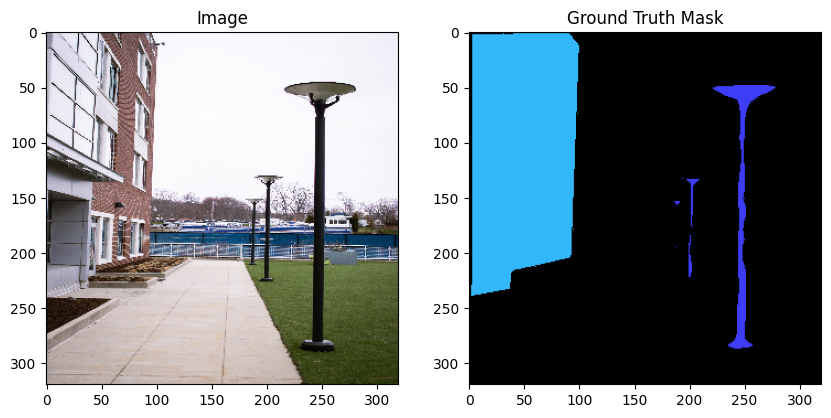

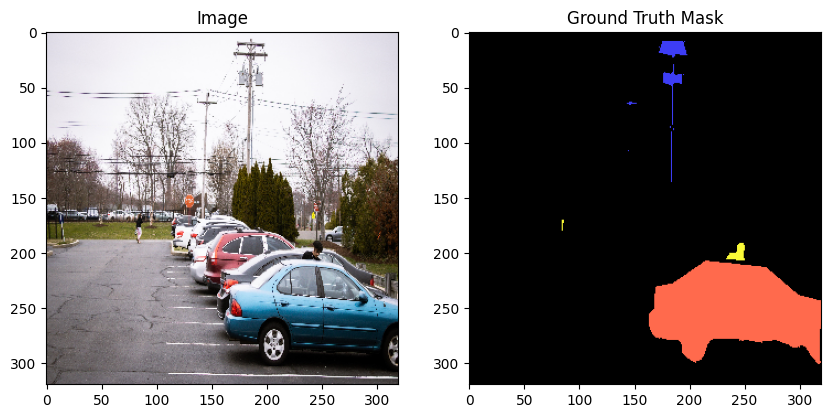

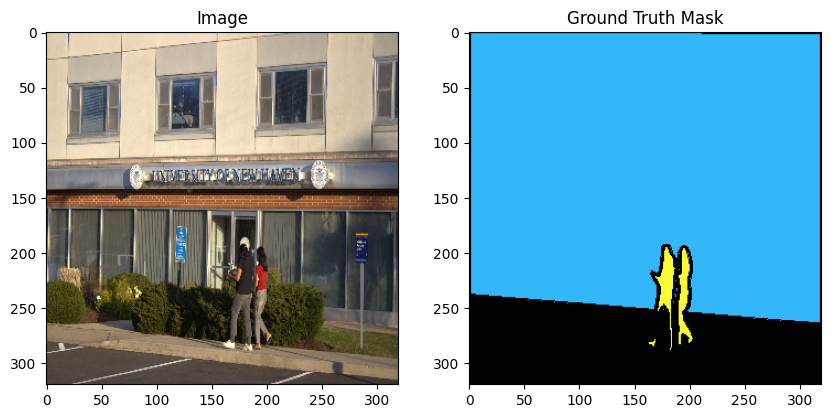

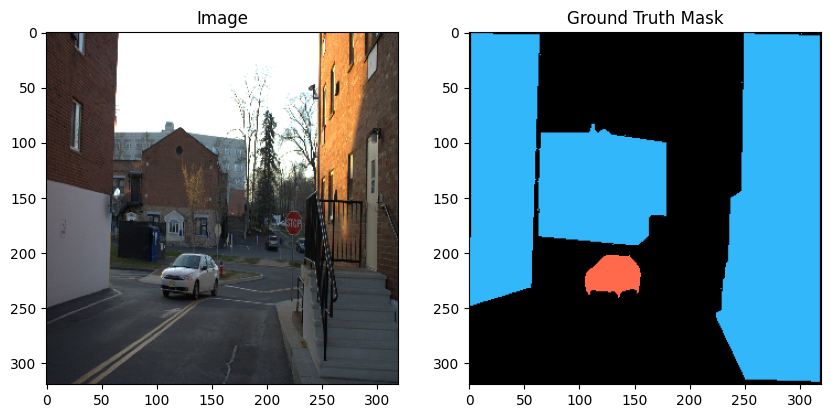

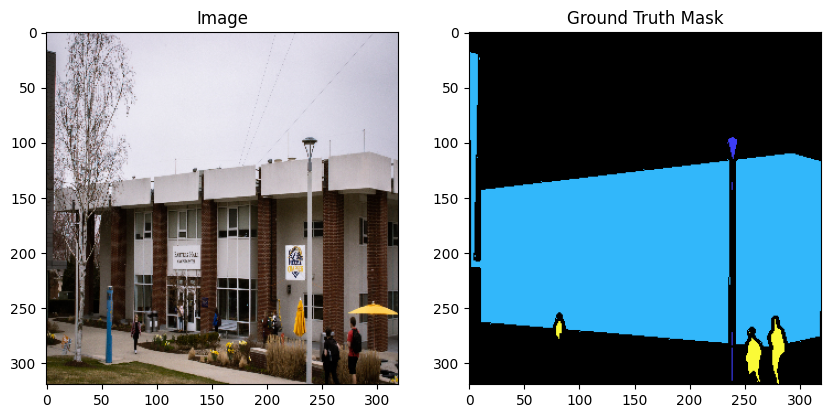

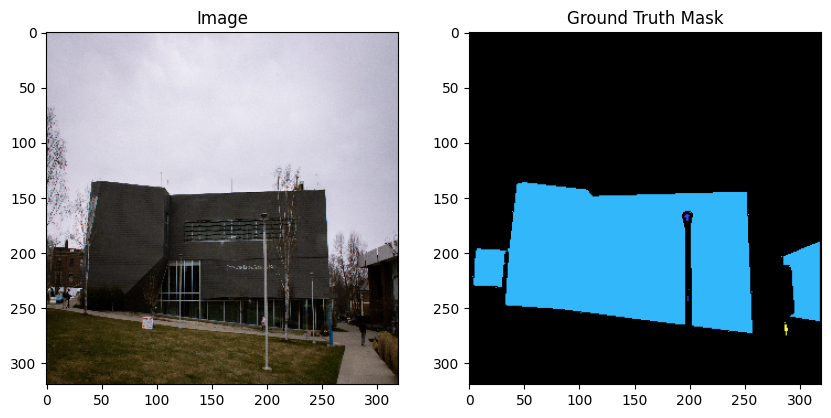

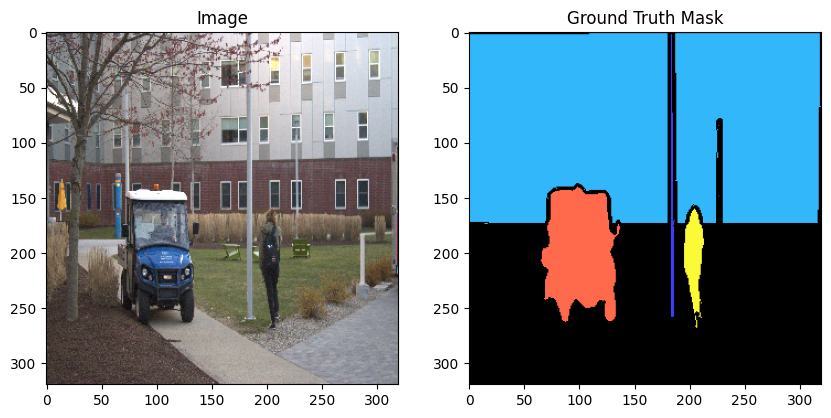

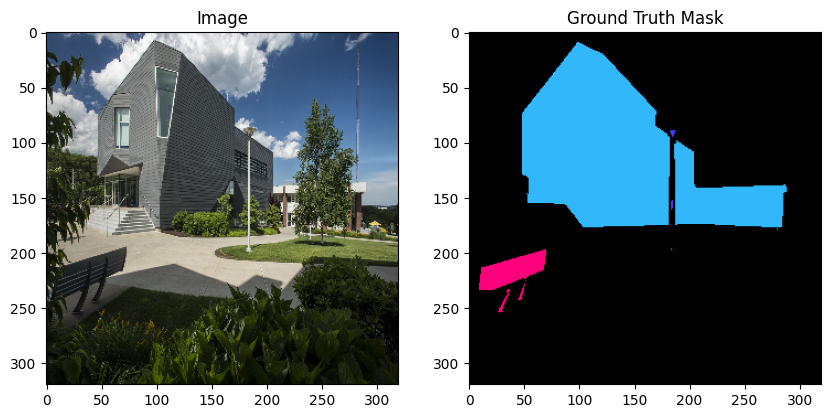

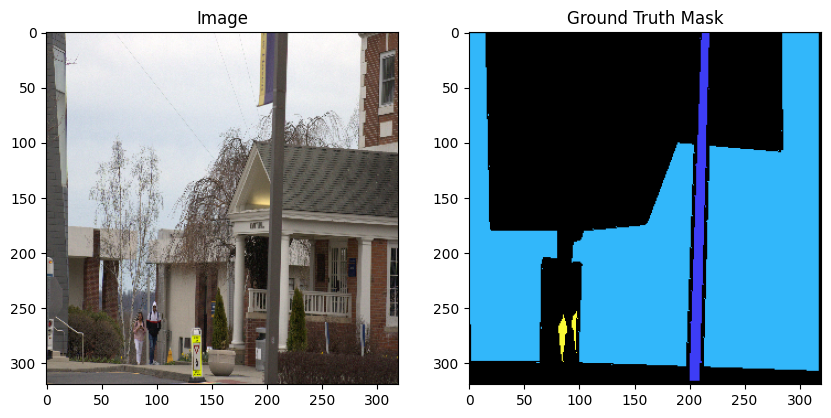

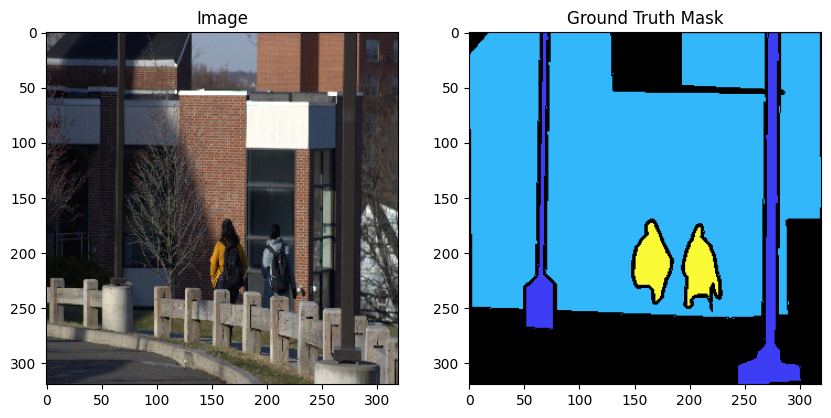

In [54]:
for orig_images, masked_images in train_dataLoader:
    fig, (ax_image, ax_ground_truth) = plt.subplots(1, 2, figsize=(10, 5))
    ax_image.set_title("Image")
    ax_ground_truth.set_title("Ground Truth Mask")

  #plotting the original image
    ax_image.imshow(orig_images[0].permute([1,2,0]).numpy())

  #Plotting the Masked image
    ax_ground_truth.imshow(mask_to_class_rgb(masked_images[0]))

    plt.show()

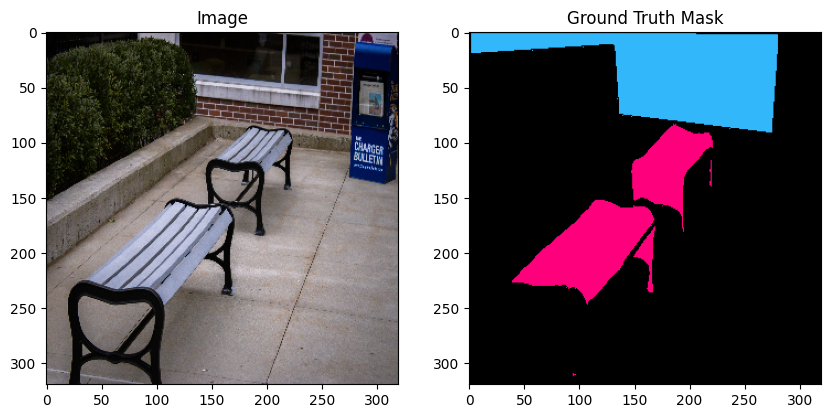

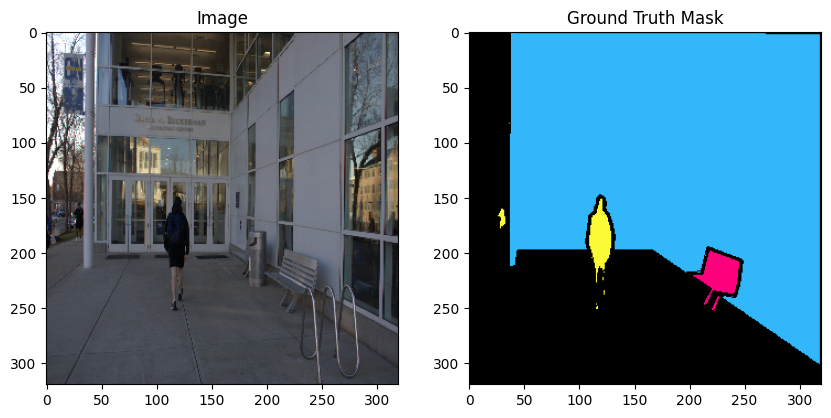

In [56]:
# Displaying one image from each batch in Val_dataLoader

for orig_images, masked_images in val_dataLoader:
    fig, (ax_image, ax_ground_truth) = plt.subplots(1, 2, figsize=(10, 5))
    ax_image.set_title("Image")
    ax_ground_truth.set_title("Ground Truth Mask")

    #plotting the original image
    ax_image.imshow(orig_images[0].permute([1,2,0]).numpy())

    #Plotting the Masked image
    ax_ground_truth.imshow(mask_to_class_rgb(masked_images[0]))

    plt.show()

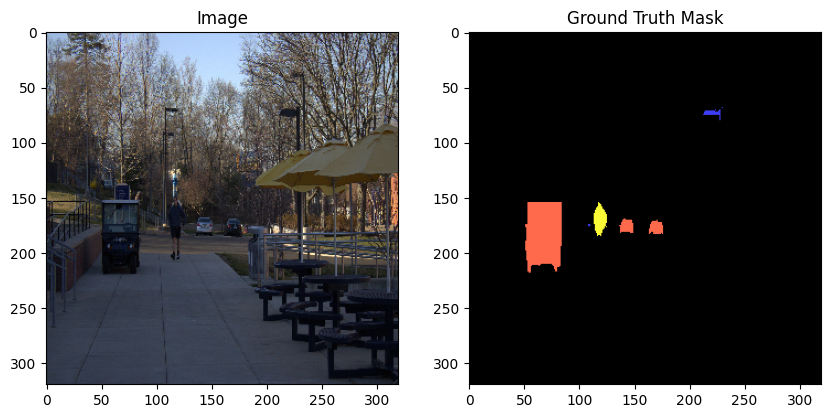

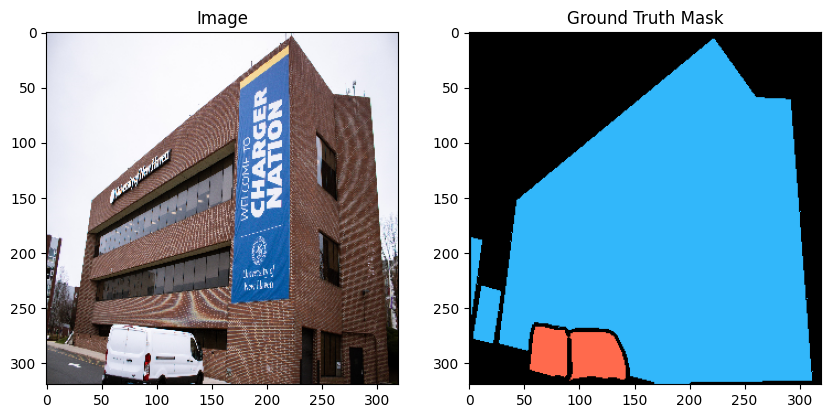

In [57]:
# Displaying one image from each batch in Test_dataLoader

for orig_images, masked_images in test_dataLoader:
    fig, (ax_image, ax_ground_truth) = plt.subplots(1, 2, figsize=(10, 5))
    ax_image.set_title("Image")
    ax_ground_truth.set_title("Ground Truth Mask")

    #plotting the original image
    ax_image.imshow(orig_images[0].permute([1,2,0]).numpy())

    #Plotting the Masked image
    ax_ground_truth.imshow(mask_to_class_rgb(masked_images[0]))

    plt.show()

In [38]:
Device = 'cuda'

In [39]:
import torch.nn.init as init
class ResNetSegmentationModel(nn.Module):
    def __init__(self):
        super(ResNetSegmentationModel, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        
        for layer in self.layer1:
            if isinstance(layer, nn.Conv2d):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )

        for layer in self.layer2:
            if isinstance(layer, nn.Conv2d):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )

        for layer in self.layer3:
            if isinstance(layer, nn.Conv2d):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        nn.init.kaiming_normal_(self.upconv1.weight, nonlinearity='relu')
        nn.init.zeros_(self.upconv1.bias)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_normal_(self.conv4.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv4.bias)
        self.bn4 = nn.BatchNorm2d(num_features=128)
        
        self.upconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        nn.init.kaiming_normal_(self.upconv2.weight, nonlinearity='relu')
        nn.init.zeros_(self.upconv2.bias)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_normal_(self.conv5.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv5.bias)
        self.bn5 = nn.BatchNorm2d(num_features=64)
        
        self.upconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        nn.init.kaiming_normal_(self.upconv3.weight, nonlinearity='relu')
        nn.init.zeros_(self.upconv3.bias)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_normal_(self.conv6.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv6.bias)
        self.bn6 = nn.BatchNorm2d(num_features=32)
    
        self.conv7 = nn.ConvTranspose2d(in_channels=32, out_channels=6, kernel_size=3, stride=2,  padding=1, output_padding=1)
        nn.init.kaiming_normal_(self.conv7.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv7.bias)
        
    
    def forward(self, x, masks=None):
        # Encoder
        enc_out = self.conv1(x)
        enc_out = self.bn1(enc_out)
        enc_out = self.relu(enc_out)
        enc_out = self.maxpool(enc_out)
        
        enc_out = self.layer1(enc_out)  # size=(N, 64, x.H/4, x.W/4)
        enc_out = self.layer2(enc_out)  # size=(N, 128, x.H/8, x.W/8)
        enc_out = self.layer3(enc_out)  # size=(N, 256, x.H/16, x.W/16)
        
        # Decoder
        dec_out = self.upconv1(enc_out)  # size=(N, 128, x.H/8, x.W/8)
        dec_out = self.conv4(dec_out)
        dec_out = self.bn4(dec_out)
        dec_out = self.relu(dec_out)
        
        dec_out = self.upconv2(dec_out)  # size=(N, 64, x.H/4, x.W/4)
        dec_out = self.conv5(dec_out)
        dec_out = self.bn5(dec_out)
        dec_out = self.relu(dec_out)
        
        dec_out = self.upconv3(dec_out)  # size=(N, 32, x.H/2, x.W/2)
        dec_out = self.conv6(dec_out)
        dec_out = self.bn6(dec_out)
        dec_out = self.relu(dec_out)
        
        outputs = self.conv7(dec_out)
        
        if masks is not None:
            masks = masks.squeeze(1)
            self.criterion = nn.CrossEntropyLoss()
            loss = self.criterion(outputs, masks)
            return outputs, loss

        return outputs

                                            

In [40]:
image, mask = next(iter(train_dataLoader))

In [41]:
model = ResNetSegmentationModel()
model.to(Device)

ResNetSegmentationModel(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, betas =(0.9,0.999))

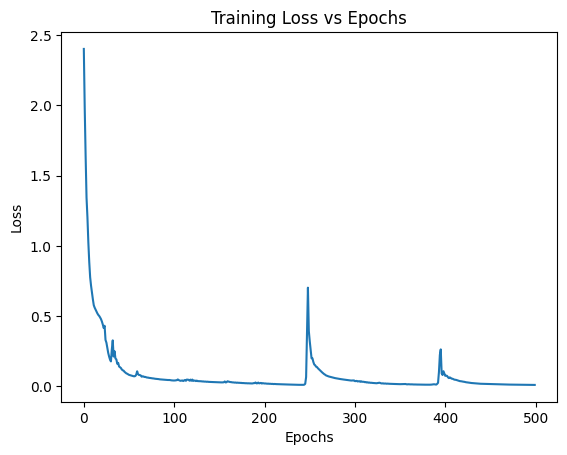

In [43]:

# training only on 2 samples!

images = image[0:2]
masks = mask[0:2]

losses = []
for epoch in range(500):
    images = images.to(Device)
    masks = masks.to(Device)
    masks = masks.long()  # Convert to integer tensor
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.mean().backward()
    optimizer.step()
    losses.append(loss.mean().item())

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.show()

In [44]:
def list_normalize(lst):
    return [(x - min(lst)) / (max(lst) - min(lst)) for x in lst]

def calc_iou(predictions, targets):
    iou_scores = []
    for prediction, target in zip(predictions, targets):
        prediction = prediction.flatten()
        target = target.flatten()
        intersection = np.sum(prediction * target)
        union = np.sum((prediction + target) > 0)
        iou = intersection / union
        iou_scores.append(iou)
    normalized_iou_scores = list_normalize(iou_scores)
    mean_iou_score = np.mean(normalized_iou_scores)
    return mean_iou_score

In [45]:
predicted_masks = []
true_masks = []

with torch.no_grad():
    for image, mask in zip(images, masks):
        logits_mask = model(image.to(Device).unsqueeze(0))
        pred_mask_prob = torch.softmax(logits_mask, dim=1)
        _, pred_mask = torch.max(pred_mask_prob, dim=1)
        pred_mask = pred_mask.detach().cpu().numpy()
        true_mask = mask.cpu().numpy()
        predicted_masks.append(pred_mask)
        true_masks.append(true_mask)

mean_iou_score = calc_iou(predicted_masks, true_masks)

In [2]:
print("Mean Intersection over Union score: %f" % mean_iou_score)

Mean Intersection over Union score: 0.100000


In [47]:
def train_model(data_loader, deep_model, optimizer):
    # Set the model to train mode
    deep_model.train()

    # Initializing the total loss to zero
    total_loss = 0

    # Create a progress bar with the description "Training" and leave as False
    progress_bar = tqdm(data_loader, desc='Training', leave=False)

    # Loop over the data in the data loader
    for i, (images, masks) in enumerate(progress_bar):
        # Move images and masks to the device
        images = images.to(Device)
        masks = masks.to(Device).long()

        # Reset the gradients to zero
        optimizer.zero_grad()

        # Forward pass to get the pred_mask and loss
        pred_mask, loss = deep_model(images, masks)

        # Compute gradients and backpropagate the loss
        loss.mean().backward()
        optimizer.step()

        # Update the total loss
        total_loss += loss.item()

        # Updating the progress bar with the current training loss
        progress_bar.set_postfix({'Training loss': total_loss / (i + 1)})

    # Return the average training loss
    return total_loss / len(data_loader)


def eval_model(data_loader, deep_model):
    # Setting the model to evaluation mode
    deep_model.eval()

    # Initialize total loss to zero
    total_loss = 0

    # Create a progress bar with the description "Evaluating" and leave as False
    progress_bar = tqdm(data_loader, desc='Evaluating', leave=False)

    # Disable gradient computation
    with torch.no_grad():
        # Loop over the data in the data loader
        for i, (images, masks) in enumerate(progress_bar):
            # Move images and masks to the device
            images = images.to(Device)
            masks = masks.to(Device).long()

            # Forward pass to get the pred_mask and loss
            pred_mask, loss = deep_model(images, masks)

            # Update the total loss
            total_loss += loss.item()

            # Update the progress bar with the current evaluation loss
            progress_bar.set_postfix({'Evaluation loss': total_loss / (i + 1)})

    # Return the average evaluation loss
    return total_loss / len(data_loader)

Training model 1/3 with hyperparameters: (0.001, (0.9, 0.999))


Saved model 1 with validation loss: 1.2593430876731873
Epoch : 1 train_loss :2.031472472044138 valid_loss :1.2593430876731873


Saved model 1 with validation loss: 0.9288712441921234
Epoch : 2 train_loss :1.2500420212745667 valid_loss :0.9288712441921234


Saved model 1 with validation loss: 0.7661888897418976
Epoch : 3 train_loss :1.0404199361801147 valid_loss :0.7661888897418976


Saved model 1 with validation loss: 0.7396209836006165
Epoch : 4 train_loss :0.9108787041444045 valid_loss :0.7396209836006165


Saved model 1 with validation loss: 0.7391180694103241
Epoch : 5 train_loss :0.8381920915383559 valid_loss :0.7391180694103241


Saved model 1 with validation loss: 0.7024639546871185
Epoch : 6 train_loss :0.8109293625904963 valid_loss :0.7024639546871185


Saved model 1 with validation loss: 0.6672878563404083
Epoch : 7 train_loss :0.7838016748428345 valid_loss :0.6672878563404083


Epoch : 8 train_loss :0.7521032874400799 valid_loss :0.6869117617607117


Saved model 1 with validation loss: 0.653826892375946
Epoch : 9 train_loss :0.7269877378757184 valid_loss :0.653826892375946


Saved model 1 with validation loss: 0.6374916136264801
Epoch : 10 train_loss :0.7287109402509836 valid_loss :0.6374916136264801
Training model 2/3 with hyperparameters: (0.01, (0.9, 0.999))


Epoch : 1 train_loss :0.9989791283240685 valid_loss :1.2096710801124573


Epoch : 2 train_loss :0.7492209489528949 valid_loss :0.6530177891254425


Epoch : 3 train_loss :0.7013086172250601 valid_loss :0.6762194633483887


Epoch : 4 train_loss :0.675506605551793 valid_loss :0.6734301745891571


Epoch : 5 train_loss :0.6766499280929565 valid_loss :0.7988438308238983


Epoch : 6 train_loss :0.6345272706105158 valid_loss :0.7888447344303131


Epoch : 7 train_loss :0.6063327009861286 valid_loss :0.6472675502300262


Saved model 2 with validation loss: 0.6243487447500229
Epoch : 8 train_loss :0.6153698494801154 valid_loss :0.6243487447500229


Epoch : 9 train_loss :0.5903245050173539 valid_loss :0.7479844987392426


Epoch : 10 train_loss :0.6064850046084478 valid_loss :0.6450911164283752
Training model 3/3 with hyperparameters: (0.1, (0.9, 0.999))


Epoch : 1 train_loss :1.099113051707928 valid_loss :293.59930419921875


Epoch : 2 train_loss :0.8789559602737427 valid_loss :62.07715606689453


Epoch : 3 train_loss :0.8416007940585797 valid_loss :4.217315435409546


Epoch : 4 train_loss :0.836475106386038 valid_loss :1.041141927242279


Epoch : 5 train_loss :0.8431917749918424 valid_loss :0.7801893651485443


Epoch : 6 train_loss :0.8310597172150245 valid_loss :2.518799901008606


Epoch : 7 train_loss :0.8347290708468511 valid_loss :2.5220006108283997


Epoch : 8 train_loss :0.7897407045731177 valid_loss :0.690616101026535


Epoch : 9 train_loss :0.7859451724932744 valid_loss :0.7096982300281525


Epoch : 10 train_loss :0.7937421110960153 valid_loss :0.8043921887874603


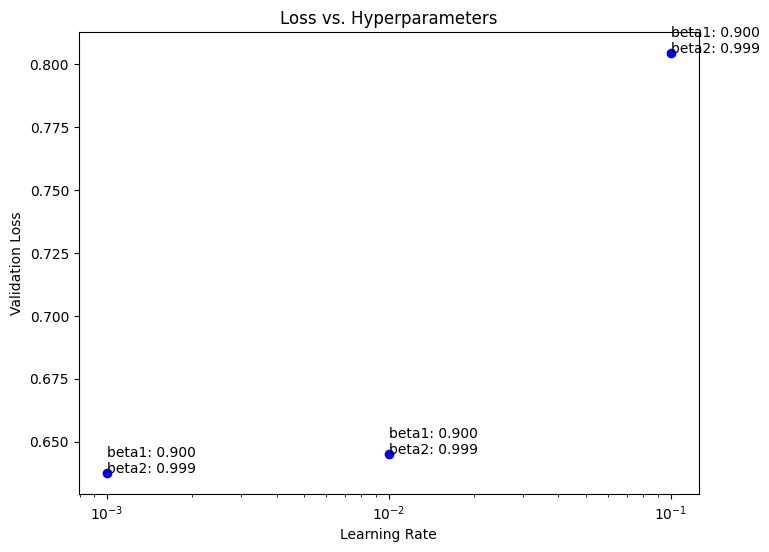

In [49]:
import matplotlib.pyplot as plt
from itertools import product

# Defining the hyperparameters
hyperparams = {
    "learning_rate": [0.001, 0.01, 0.1],
    "betas": [(0.9, 0.999)],
}

# Generate all possible combinations of hyperparameters
search_space = list(product(*hyperparams.values()))

# Setting the initial best validation loss to 1000
best_valid_loss = 1000

# Lists to store the hyperparameters and their corresponding validation losses
hyperparam_list = []
valid_loss_list = []

# Loop over the hyperparameter combinations and fine-tune the model
for i, hyperparameters in enumerate(search_space):
    print(f"Training model {i+1}/{len(search_space)} with hyperparameters: {hyperparameters}")
    
    # Initializing the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters[0], betas=hyperparameters[1])

    # Defining the fine-tuned path
    fine_tuned_path = f'/content/drive/MyDrive/DeepLearning_Dataset/miniNetwork_tuned_{i+1}.pth'

    # Training the model for 10 epochs
    for epoch in range(10):
        train_loss = train_model(train_dataLoader , model , optimizer)
        valid_loss = eval_model(val_dataLoader , model )

        if valid_loss < best_valid_loss:
            # Saving the fine-tuned model to the specified path
            torch.save(model.state_dict(), fine_tuned_path)
            print(f"Saved model {i+1} with validation loss: {valid_loss}")
            best_valid_loss = valid_loss

        print(f"Epoch : {epoch+1} train_loss :{train_loss} valid_loss :{valid_loss}")

    # Append the hyperparameters and their corresponding validation losses to the lists
    hyperparam_list.append(hyperparameters)
    valid_loss_list.append(valid_loss)

# Plotting the loss versus hyperparameters graph
plt.figure(figsize=(8,6))
for i, hyperparams in enumerate(hyperparam_list):
    lr = hyperparams[0]
    beta1, beta2 = hyperparams[1]
    plt.scatter(lr, valid_loss_list[i], marker='o', color='blue')
    plt.annotate(f'beta1: {beta1:.3f}\nbeta2: {beta2:.3f}', (lr, valid_loss_list[i]))
plt.title('Loss vs. Hyperparameters')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.xscale('log')
plt.show()


In [50]:
def evaluate_test_data(index):
    # Get image and mask from test dataset
    image, mask = test_dataSet[index]
    pred_mask = model(image.to(Device).unsqueeze(0)) 

    # Compute predicted mask probabilities using softmax
    predicted_mask_prob = torch.softmax(pred_mask, dim=1)  

    # Get predicted mask by selecting the class with highest probability
    max_values, predicted_mask = torch.max(predicted_mask_prob, dim=1)  

    # Display the original image, true mask, and predicted mask
    fig, (ax_image, ax_ground_truth, ax_model_output) = plt.subplots(1, 3, figsize=(10, 5))

    ax_image.set_title('Image')
    ax_image.imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')

    ax_ground_truth.set_title('Ground Truth Mask')
    ax_ground_truth.imshow(mask_to_class_rgb(mask))

    ax_model_output.set_title('Model Output Mask')
    ax_model_output.imshow(mask_to_class_rgb(predicted_mask))


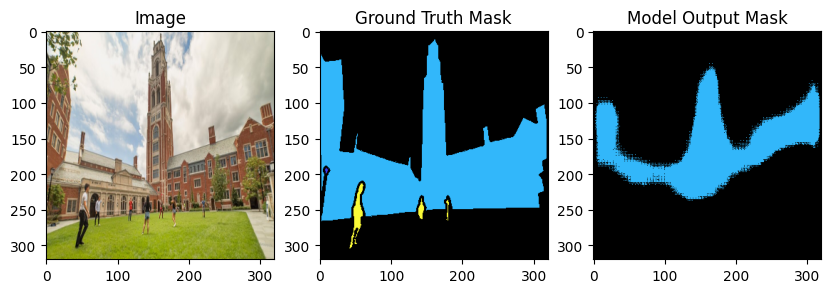

In [59]:
import random

best_model_path = f'/content/drive/MyDrive/DeepLearning_Dataset/miniNetwork_tuned_2.pth'
# Load the saved model parameters
model_params = torch.load(best_model_path, map_location=torch.device('cuda'))

model.load_state_dict(model_params)

# model.load_state_dict(torch.load(best_model_path))
for index in random.sample(list(range(len(test_dataSet))), 1):

    evaluate_test_data(index)

In [55]:
predicted_masks = []
true_masks = []

with torch.no_grad():
    for image, mask in test_dataSet:
        logits_mask = model(image.to(Device).unsqueeze(0))
        pred_mask_prob = torch.softmax(logits_mask, dim=1)
        _, pred_mask = torch.max(pred_mask_prob, dim=1)
        pred_mask = pred_mask.detach().cpu().numpy()
        true_mask = mask.cpu().numpy()
        predicted_masks.append(pred_mask)
        true_masks.append(true_mask)

mean_iou_score = calc_iou(predicted_masks, true_masks)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [3]:
print("Mean Intersection over Union score: %f" % mean_iou_score)


Mean Intersection over Union score: 0.900000
